In [1]:
import warnings
from ultralytics import YOLO
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from yolo_cam.ablation_cam import AblationCAM
from yolo_cam.ablation_layer import AblationLayerFasterRCNN
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

WARNING  user config directory is not writeable, defaulting to '/tmp/Ultralytics'.


In [2]:
def parse_detections(detections):
    boxes, colors, names = [], [], []    

    for i in range(len(detections["xmin"])):
        confidence = float(detections["confidence"][i])
        if confidence < 0.2:
            continue
        xmin = int(float(detections["xmin"][i]))
        ymin = int(float(detections["ymin"][i]))
        xmax = int(float(detections["xmax"][i]))
        ymax = int(float(detections["ymax"][i]))
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes
def camtest(image_path):
    img = np.array(Image.open(image_path))
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = img.astype(np.float32) / 255.0
    results = model([rgb_img])
    boxes = results[0].boxes
    columns = ['xmin', 'ymin',	'xmax', 'ymax',	'confidence', 'class', 'name']
    bbox = boxes.xyxy[0].cpu().numpy()
    conf = float(boxes.conf.cpu().numpy())
    cls = int(boxes.cls[0])
    name = (results[0].names[int(boxes.cls[0])])
    print("Confidence:", conf)
    print("Class: ", name)
    data = np.array([bbox[0],bbox[1],bbox[2],bbox[3], conf, cls, name ])
    detections = pd.DataFrame([data], columns=columns)
    boxes, colors, names = parse_detections(detections)
    detection = draw_detections(boxes, colors, names, rgb_img.copy())
    cam = EigenCAM(model, target_layers)
    grayscale_cam = cam(rgb_img)[0, :, :]
    g_scale = np.stack([grayscale_cam] * 3, axis=2)
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
    return detection, cam_image, g_scale, renormalized_cam_image
    

In [3]:
image_path = "/home/antonino/Università/laurea/script test/xai/speedboat.jpg"
img = np.array(Image.open(image_path))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = img.astype(np.float32) / 255.0
model = YOLO('/home/antonino/Università/porto/train/train/weights/best.pt')
#model = YOLO('yolov8n.pt')

In [4]:
target_layers = [model.model.model[-7]]

In [5]:
results = model([rgb_img])
boxes = results[0].boxes


0: 640x640 1 Speed Boat, 55.8ms
Speed: 6.4ms preprocess, 55.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


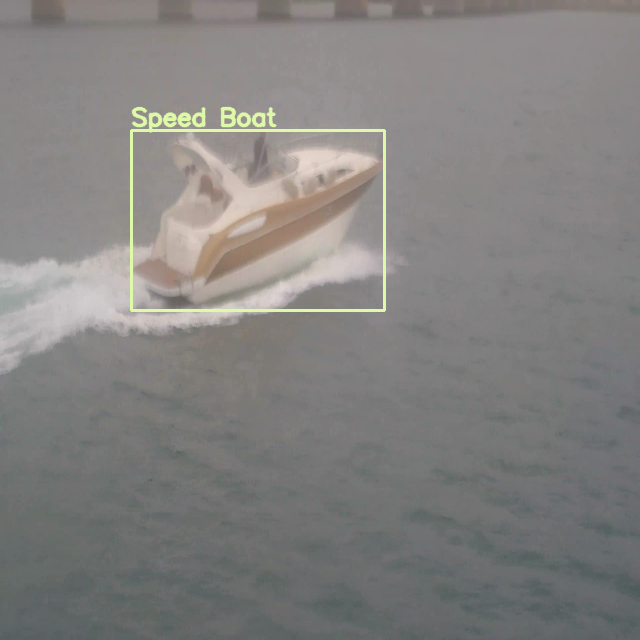

In [6]:
import pandas as pd
columns = ['xmin', 'ymin',	'xmax', 'ymax',	'confidence', 'class', 'name']
bbox = boxes.xyxy[0].cpu().numpy()
conf = float(boxes.conf.cpu().numpy())
cls = int(boxes.cls[0])
name = (results[0].names[int(boxes.cls[0])])
data = np.array([bbox[0],bbox[1],bbox[2],bbox[3], conf, cls, name ])
detections = pd.DataFrame([data], columns=columns)
boxes, colors, names = parse_detections(detections)
detection = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detection)

In [7]:
from yolo_cam.utils.reshape_transforms import fasterrcnn_reshape_transform

In [8]:
cam = AblationCAM(model,
               target_layers,
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN())

In [9]:
grayscale_cam = cam(rgb_img)

TypeError: 'bool' object is not callable